# 처음 설정

In [306]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [307]:
import os
os.chdir('/content/drive/MyDrive/015GithubRepos/da_for_sbr')

import pickle
import os
import matplotlib.pyplot as plt
from collections import Counter
import math
import numpy as np

from simmetric import *
from utils import *

experiment = 1

# colab
dataPATH = '/content/drive/MyDrive/015GithubRepos/da_for_sbr/exps'
expPATH = '/content/drive/MyDrive/015GithubRepos/da_for_sbr/exps'

# spyder
# dataPATH = 'G:/내 드라이브/015GithubRepos/da_for_sbr/exps'
# expPATH = 'G:/내 드라이브/015GithubRepos/da_for_sbr/exps'


if not os.path.exists(f'exps/experiment{experiment}'):
    os.makedirs(f'exps/experiment{experiment}')


# from preprocessing import *

# 불러올 데이터 선택
y_or_d = 'yoochoose'  # yoochoose or diginetica
frac = 1/64

# tra_seqs_frac : 아이템 시퀀스
tra_seqs_frac = load_tra_seqs_frac(experiment, y_or_d, frac)
nof_sessions = len(tra_seqs_frac)

# allaprcnt : 모든 출현 카운트
allsess = []
for s in tra_seqs_frac:
  allsess += s

allaprcnt = len(allsess)
print(f'모든 세션의 아이템 출현 수 : {allaprcnt}')

# allitemcntr : 아이템별 출현횟수 카운트
allitemcntr = Counter(allsess)

# nof_items : 아이템 수
nof_items = len(allitemcntr)

print(f'총 아이템 수 : {nof_items}')

loading file : exps/experiment1/yoochoose/y064_tra_seqs.pkl
124472
모든 세션의 아이템 출현 수 : 519275
총 아이템 수 : 17597


# 데이터 증강

## 스코어 딕셔너리 생성

### 스코어 계산 첫 번째 방법

In [ ]:
#%% falog2만들기, hs딕셔너리(msd, most hightest similarity dictionary) 불러오기


falog2 = {k:math.log2(v+1) for k, v in allitemcntr.items()}

from simmetric import *
msd = load_msd('coo', experiment, y_or_d, frac)


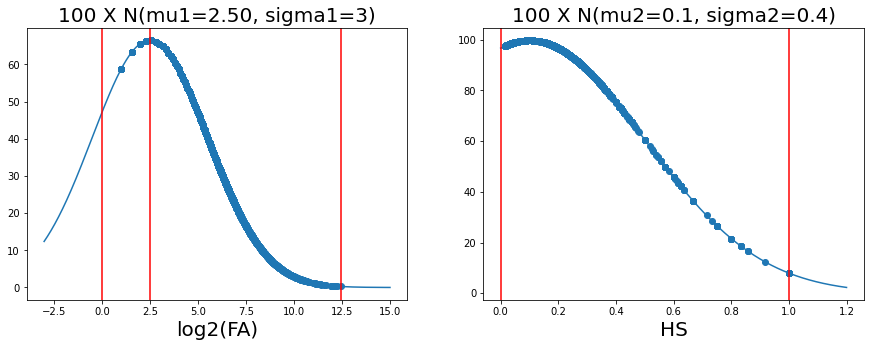

In [ ]:
#%% hyperparameter setting

alpha = 500
mu1 = 2.5
sigma1 = 3

beta = 500
mu2 = 0.1
sigma2 = 0.4




#%% 출현빈도 그리기 ##############################################


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)


min(falog2.values())
min(allitemcntr.values())


M = max(falog2.values())

# x, y 생성
x = [falog2[i] for i in range(1, nof_items+1)]
y = [alpha * gaussian(mu1, sigma1, _) for _ in x]
plt.scatter(x, y)

# 가우시안 선
x = np.linspace(-3, 15, 1000)
y = gaussian(mu1, sigma1, x) * alpha
plt.plot(x, y)

# 수선
plt.axvline(x=0, color='r')
plt.axvline(x=mu1, color='r')
plt.axvline(x=M, color='r')


plt.xlabel('log2(FA)', fontsize=20)
plt.title(f'100 X N(mu1={mu1:.2f}, sigma1={sigma1})', fontsize=20)
#####################################################################


#%%

plt.subplot(1, 2, 2)

x = [msd[i][1] for i in range(1, nof_items+1)]
y = [100*gaussian(mu2, sigma2, _) for _ in x]

plt.scatter(x, y)

# 가우시안 선
x = np.linspace(0, 1.2, 1000)
y = gaussian(mu2, sigma2, x) * 100
plt.plot(x, y)

# 수선
plt.axvline(x=0, color='r')
plt.axvline(x=1, color='r')


plt.xlabel('HS', fontsize=20)
plt.title(f'100 X N(mu2={mu2}, sigma2={sigma2})', fontsize=20)
#####################################################################

theta = [alpha, mu1, sigma1, beta, mu2, sigma2]

def cal_score(logfa: float , hsvalue: float, theta) -> float:

  alpha, mu1, sigma1, beta, mu2, sigma2 = theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]

  alphaterm = alpha * gaussian(mu1, sigma1, logfa)
  betaterm = beta * gaussian(mu2, sigma2, hsvalue)

  score = alphaterm + betaterm

  return score

score = {i : cal_score(falog2[i], msd[i][1], theta) for i in range(1, nof_items+1)}

---

### 스코어 계산 두 번째 방법
(출현빈도 낮고 최고유사도 값 높은 아이템에만 집중한 증강 프로세스 정립?)

$s = \frac{100HS}{\sqrt{FA}}$

In [ ]:
# msd 로드
msd = load_msd('coo', experiment, y_or_d, frac)

# 출현빈도 역수
fa_sqrt = {k:v for k, v in allitemcntr.items()}
score = {i: 100 * msd[i][1]/fa_sqrt[i] for i in range(1, nof_items+1)}  # 아이템별 score 딕셔너리 계산

In [ ]:
for sid in [51, 8432, 8468, 50000, 68880, 98070, 120000]:
  testss = tra_seqs_frac[sid].copy()
  print(f'아이템 \t FA \t (FA) \t HS \t \t 100HS \t\t Score')
  for idx in range(len(testss)):
      item = testss[idx]
      print(f'{item:5} \t {allitemcntr[item]:4} \t {fa_sqrt[item]:^10.2f} \t {msd[item][1]:>6.4f} \t {msd[item][1]*100:>6.2f} \t {score[item]:.4f}')

  m = np.mean([score[i] for i in testss])
  print(f'mean = {m:.4f}')
  
  print()

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
   55 	 4355 	  4355.00   	 0.0499 	   4.99 	 0.0011
    5 	 3999 	  3999.00   	 0.1312 	  13.12 	 0.0033
mean = 0.0022

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
   14 	 1447 	  1447.00   	 0.0574 	   5.74 	 0.0040
   13 	 2622 	  2622.00   	 0.1033 	  10.33 	 0.0039
  134 	 1578 	  1578.00   	 0.0919 	   9.19 	 0.0058
   12 	 2740 	  2740.00   	 0.1066 	  10.66 	 0.0039
mean = 0.0044

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
  518 	 1310 	  1310.00   	 0.1019 	  10.19 	 0.0078
  164 	 1571 	  1571.00   	 0.0851 	   8.51 	 0.0054
  133 	 1623 	  1623.00   	 0.0873 	   8.73 	 0.0054
mean = 0.0062

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
  176 	 2471 	  2471.00   	 0.0384 	   3.84 	 0.0016
  176 	 2471 	  2471.00   	 0.0384 	   3.84 	 0.0016
mean = 0.0016

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
  118 	  485 	   485.00   	 0.0343 	   3.43 	 0.0071
  776 	  905 	   905.00   	 0.0840 	   8.40 	 0.0093
mean = 0.0082

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Sc

### 네 번째 방법 세션들의 FA, HS 평균 계산

In [ ]:
msd[3]

(157, 0.03709591944886063)

In [ ]:
allitemcntr[4]

2603

In [ ]:
i

124472

In [ ]:
nof_sessions

124472

In [ ]:
len(tra_seqs_frac)

124472

In [308]:
fas = []
hss = []
scores=[]
nof_i = []


rand_idxs = np.random.randint(1, nof_sessions+1, size=10000)
for i in range(1, nof_sessions):
  s = tra_seqs_frac[i]
  fas.append(np.mean([allitemcntr[_] for _ in s]))
  hss.append(np.mean([msd[_][1] for _ in s]))
  scores.append(np.mean([score[_] for _ in s]))
  nof_i.append(len(s))

nof_i = np.array(nof_i)*100

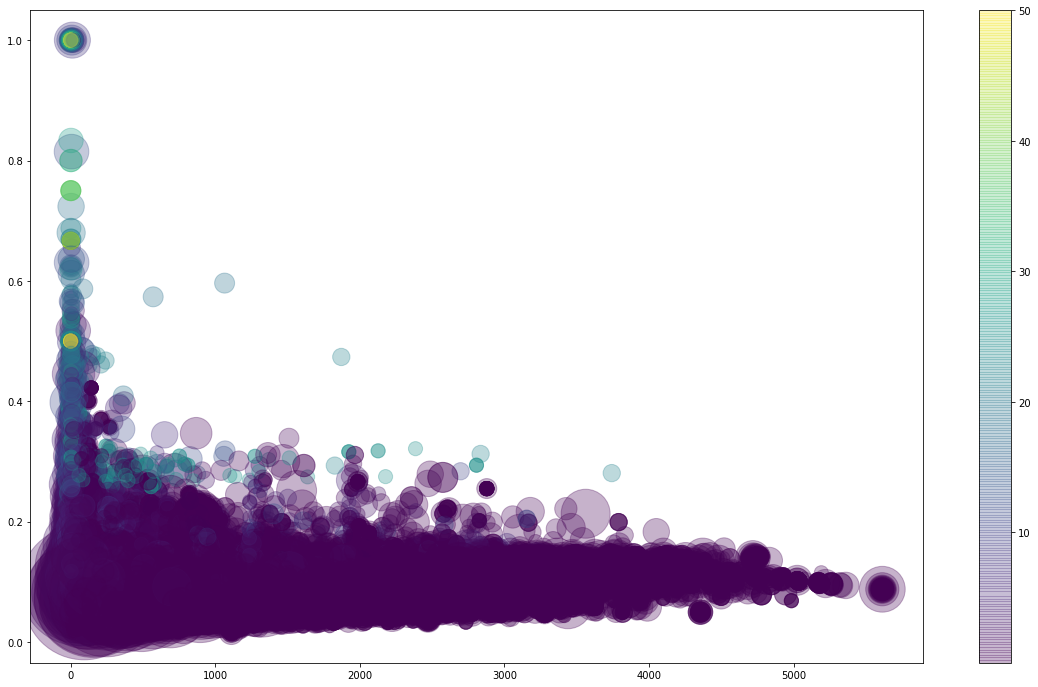

In [ ]:
plt.figure(figsize=(20, 12))

plt.scatter(fas, hss, c=scores, alpha=0.3, s=nof_i)
plt.colorbar()

In [310]:
score = {i: 100 * msd[i][1]/fa_sqrt[i] for i in range(1, nof_items+1)}  # 아이템별 score 딕셔너리 계산

In [311]:
coo_mat = load_sim_mat('coo', 1, 'yoochoose', 1/64)

로드 유사도행렬 : exps/experiment1/yoochoose/y064_csr_coo_mat.pkl


In [312]:
def get_sim_betclus(cl1, cl2):

  sims = []
  for a in cl1:
    for b in cl2:
      sims.append(coo_mat[a][b])

  return np.mean(sims)

In [318]:
clusters = {}
for i in range(1, nof_items+1):
  temp = set()
  temp.add(i)
  clusters[i] = temp

keepgo = 1
while keepgo:
  for cl_id in range(1, nof_items+1):  # 클러스터링 전체 한바퀴
    if cl_id in clusters:
      maxsim = 0
      maxid = cl_id
      for oth_cl_id in range(1, nof_items+1):  # 자기 빼고 다른아이템 돌면서
        if cl_id != oth_cl_id and oth_cl_id in clusters:
          sim = get_sim_betclus(clusters[cl_id], clusters[oth_cl_id])
          if maxsim < sim:
            maxsim = sim
            maxid = oth_cl_id

      clusters[cl_id] = clusters[cl_id].union(clusters[maxid])
      del clusters[maxid]
      print(len(clusters))
      if len(clusters) == 4:
        keepgo = 0
        break


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5003
5002
5001
5000
4999
4998
4997
4996
4995
4994
4993
4992
4991
4990
4989
4988
4987
4986
4985
4984
4983
4982
4981
4980
4979
4978
4977
4976
4975
4974
4973
4972
4971
4970
4969
4968
4967
4966
4965
4964
4963
4962
4961
4960
4959
4958
4957
4956
4955
4954
4953
4952
4951
4950
4949
4948
4947
4946
4945
4944
4943
4942
4941
4940
4939
4938
4937
4936
4935
4934
4933
4932
4931
4930
4929
4928
4927
4926
4925
4924
4923
4922
4921
4920
4919
4918
4917
4916
4915
4914
4913
4912
4911
4910
4909
4908
4907
4906
4905
4904
4903
4902
4901
4900
4899
4898
4897
4896
4895
4894
4893
4892
4891
4890
4889
4888
4887
4886
4885
4884
4883
4882
4881
4880
4879
4878
4877
4876
4875
4874
4873
4872
4871
4870
4869
4868
4867
4866
4865
4864
4863
4862
4861
4860
4859
4858
4857
4856
4855
4854
4853
4852
4851
4850
4849
4848
4847
4846
4845
4844
4843
4842
4841
4840
4839
4838
4837
4836
4835
4834
4833
4832
4831
4830
4829
4828
4827
4826
4825
4824
4823
4822
4821
4820
4819
4818
4817
4816
4815
4814
4813
4812
4811

In [320]:
clusters.keys()

dict_keys([9737, 14338, 15361, 16716])

In [ ]:
fas = []
hss = []
scores=[]
nof_i = []


rand_idxs = np.random.randint(1, nof_sessions+1, size=10000)
for i in range(1, nof_sessions):
  s = tra_seqs_frac[i]
  fas.append(np.mean([allitemcntr[_] for _ in s]))
  hss.append(np.mean([msd[_][1] for _ in s]))
  scores.append(np.mean([score[_] for _ in s]))
  nof_i.append(len(s))

nof_i = np.array(nof_i)*100

In [339]:
for _ in clusters.keys():
  break
  clusters[_]

In [340]:
_

9737

9737 2532
14338 2319
15361 3311
16716 8355


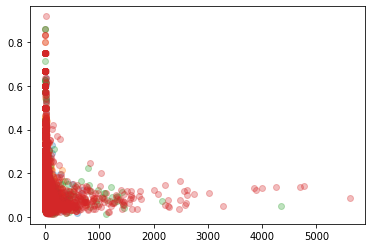

In [346]:

for _ in clusters.keys():
  print(_, len(clusters[_]))
  x = [allitemcntr[i] for i in clusters[_]]
  y = [msd[i][1] for i in clusters[_]]
  plt.scatter(x, y, alpha=0.3)

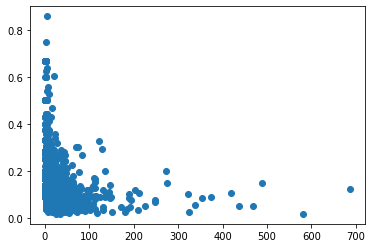

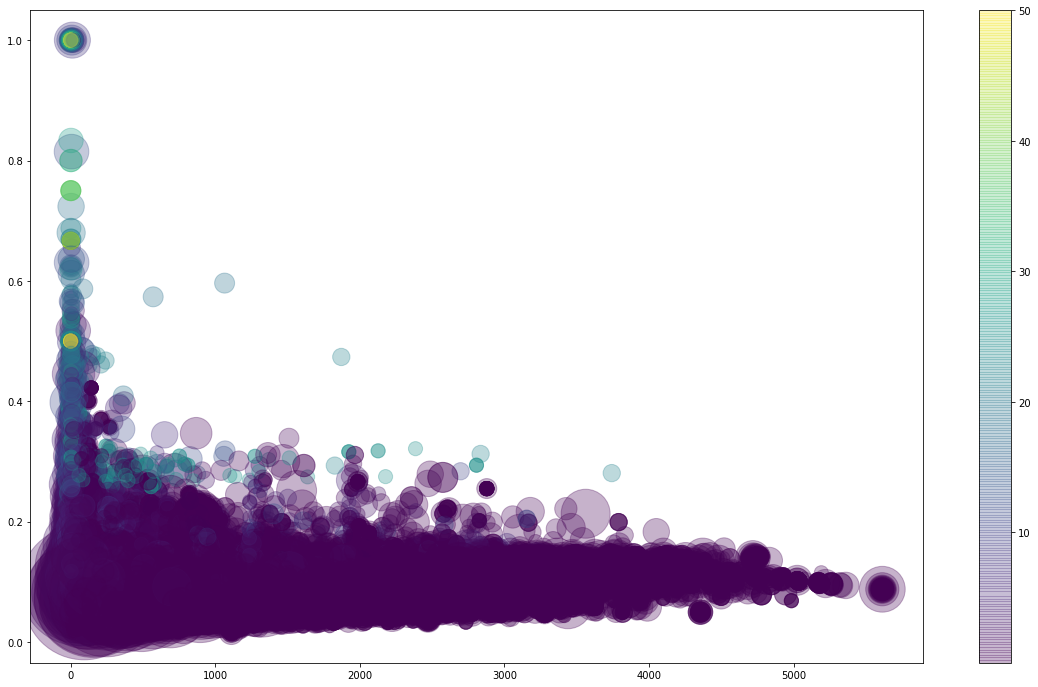

In [ ]:
for cidx in clusters.keys():
  plt.scatter()


plt.figure(figsize=(20, 12))

plt.scatter(fas, hss, c=scores, alpha=0.3, s=nof_i)
plt.colorbar()

In [ ]:
plt.scatter

## 세션을 스코어평균 높은순으로 정렬

In [ ]:
sess_s_mean = dict()
for sid, s in enumerate(tra_seqs_frac):
  scorelist = [score[item] for idx, item in enumerate(s)]
  sess_s_mean[sid] = (np.mean(scorelist), len(s))  # sess_s_mean[session id] = (session's score mean, session length)

aug_target = sorted(sess_s_mean.items(), key=lambda x: (x[1][0], -x[1][1]), reverse=True)
aug_target[:10]  # (세션id, (스코어평균, 아이템수))

[(156, (50.0, 2)),
 (223, (50.0, 2)),
 (1219, (50.0, 2)),
 (1303, (50.0, 2)),
 (2170, (50.0, 2)),
 (2501, (50.0, 2)),
 (2731, (50.0, 2)),
 (2846, (50.0, 2)),
 (3113, (50.0, 2)),
 (3221, (50.0, 2))]

In [ ]:
aug_target_idx = [_[0] for _ in aug_target]
aug_target_idx[:10]  # 스코어평균 상위 10개 세션의 id

[156, 223, 1219, 1303, 2170, 2501, 2731, 2846, 3113, 3221]

## 정렬 후 위부터 증강
(증강 안되는 세션은 건너뛰기)

### 파라미터 설정

In [ ]:
ar = 0.2  # augmentation rate
nof_aug = int(nof_sessions * ar)  # number of augmentation
print(f'number of sessions : {nof_sessions} \naugmentation rate(ar) : {ar}\nhow many sessions to augment : {nof_aug}')

cr = 0.3  # choice rate
print(f'choice rate : {ar}')

number of sessions : 124472 
augmentation rate(ar) : 0.2
how many sessions to augment : 24894
choice rate : 0.2


In [ ]:
cnt = 0  # 증강 성공할때마다 하나씩 카운트
aug_sess = []  # 증강 완료된 세션을 모음


for rank, sid in enumerate(aug_target_idx):

  s = tra_seqs_frac[sid].copy()  # 안변하고 참고하는거
  sess = tra_seqs_frac[sid].copy()  # 실제로 변하는거
  slen = len(sess)

  scorelist = np.array([score[item] for item in sess])

  np.random.choice(range(len(sess)), math.floor(len(sess) * cr))

  p = np.array(scorelist) / np.sum(scorelist)

  augidxs = np.random.choice(range(len(sess)), math.floor(len(sess) * cr), replace=False, p=p)

  nof_sub = np.random.choice(slen + 1, 1)[0]  # 대체할 개수
  sub_it_idxs = augidxs[:nof_sub]
  isrt_it_idxs = augidxs[nof_sub:]


  # sforsub에 대체
  for sitidx in sub_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기 자신과만 유사한 아이템만 아니면 대체
    mostsimitem_s = msd[sess[sitidx]][0]
    if sess[sitidx] != mostsimitem_s:
      sess[sitidx] = mostsimitem_s  # 대체
  
  # 삽입할 아이템 구하기
  isrt_items = []  # 삽입할 아이템을 모음
  isrt_it_idxs_over = []  # 삽입할 인덱스를 모음
  for iitidx in isrt_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기자신과만 유사한 아이템 아니면 삽입
    mostsimitem_i = msd[sess[iitidx]][0]
    if sess[iitidx] != mostsimitem_i:
      isrt_items.append(mostsimitem_i)  # 삽입할 아이템
      isrt_it_idxs_over.append(iitidx)  # 삽입할 인덱스

  sess = np.insert(np.asarray(sess), isrt_it_idxs_over, isrt_items)  # 삽입
  sess = list(sess)

  if s != sess:
    cnt += 1
    print(f'************성공**************')
    aug_sess.append(sess)
  


  print(f'순위 : {rank}')
  print(f'원래 세션   : {s}')
  print(f'증강된 세션 : {sess}')
  a, b, c, d, e, f = '아이템', 'FA', 'sqrt(FA)', 'HS', '100HS', 'score'
  print(f'{a:>10}{b:^10}{c:^10}{d:^10}{e:^10}{f:^10}')
  for idx in range(len(s)):
    item = s[idx]
    print(f'{item:>10}{allitemcntr[item]:^10}{fa_sqrt[item]:^10.2f}{msd[item][1]:^10.4f}{msd[item][1]*100:^10.2f}{score[item]:^10.2f}')
  
  print(f'p : [', end='')
  for _ in p:
    print(f'{_:.4f}', end=' ')
  print(f']')
  print(f'score mean: {np.mean(scorelist):.2f}')
  print()

  if cnt == nof_aug:
    break



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
       아이템    FA     sqrt(FA)     HS      100HS     score   
       773   443      443.00    0.1192    11.92      0.03   
       111   2549    2549.00    0.1175    11.75      0.00   
        10   2476    2476.00    0.1637    16.37      0.01   
      1825   197      197.00    0.1580    15.80      0.08   
p : [0.2274 0.0390 0.0559 0.6778 ]
score mean: 0.03

순위 : 60262
원래 세션   : [89, 12, 7556]
증강된 세션 : [89, 12, 7556]
       아이템    FA     sqrt(FA)     HS      100HS     score   
        89   1756    1756.00    0.1182    11.82      0.01   
        12   2740    2740.00    0.1066    10.66      0.00   
      7556   105      105.00    0.0820     8.20      0.08   
p : [0.0759 0.0439 0.8803 ]
score mean: 0.03

************성공**************
순위 : 60263
원래 세션   : [302, 11931, 217, 561]
증강된 세션 : [302, 165, 217, 561]
       아이템    FA     sqrt(FA)     HS      100HS     score   
       302   568      568.00    0.0515     5.15      0.01   
     11931    74      74.00    

## 저장

In [ ]:
len(aug_sess)

24894

In [ ]:
aug_tra, aug_tra_l = crop_seqs(tra_seqs_frac + aug_sess)
aug_tra_final = (aug_tra, aug_tra_l)

filename_save = f'exps/experiment{experiment}/{y_or_d}/{y_or_d[0]}{int(1/frac):03}_thirdmethodar{ar}cr{cr}.txt'
print(filename_save)

exps/experiment1/yoochoose/y064_thirdmethodar0.2cr0.3.txt


In [ ]:
pickle.dump(aug_tra_final, open(filename_save, 'wb'))

# 모델 돌리기

In [ ]:
from models import narm, srgnn

## NARM

In [ ]:
trainfiles = [
              'y064_thirdmethodar0.2cr0.3.txt'
              ]


narm(trainfiles, 1, 'yoochoose', 1/64)

Namespace(batch_size=512, embed_dim=50, epoch=100, hidden_size=100, lr=0.001, lr_dc=0.1, lr_dc_step=80, test=False, test_file='exps/', topk=20, train_file='exps/', valid=False, valid_portion=0.1)
--------------------------------------------------
Dataset info:
Number of sessions: 581004
--------------------------------------------------
--------------------------------------------------
Dataset info:
Number of sessions: 55424
--------------------------------------------------
아이템 개수 : 17597
1 ~ 17597
모델에 들어가는 수 : 17598


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Epoch 0 : Recall@20: 36.1651, MRR@20: 18.1683 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt
Epoch 1 : Recall@20: 47.5900, MRR@20: 21.6119 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt
Epoch 2 : Recall@20: 54.0317, MRR@20: 23.6379 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt
Epoch 3 : Recall@20: 57.8125, MRR@20: 25.1075 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt
Epoch 4 : Recall@20: 60.3390, MRR@20: 25.8160 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt
Epoch 5 : Recall@20: 61.9356, MRR@20: 26.4968 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt
Epoch 6 : Recall@20: 63.2472, MRR@20: 26.7643 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt
Epoch 7 : Recall@20: 64.4961, MRR@20: 27.3525 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt
Epoch 8 : Recall@20: 65.1842, MRR@20: 27.4394 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt
Epoch 9 : Recall@20: 65.8436, MRR@20: 27.7890 	y064_thirdmethodar0.2cr0.3.txt 	 1/1 	 y064_test.txt


## SRGNN

In [ ]:
trainfiles = [
              'y064_thirdmethodar0.3cr0.3 - 복사본.txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (2).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (3).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (4).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (5).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (6).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (7).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (8).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (9).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (10).txt'
              ]

# 모델명(train_fns:학습 파일 리스트, experiment, y_or_d, frac)
srgnn(trainfiles, 1, 'yoochoose', 1/64)

# 시각화

file name                                hits                 	 mrrs                

y064_train.txt                           70.6404               	 30.0955             
y064_train2.txt                          70.5006               	 30.1899             
y064_train3.txt                          70.9217               	 30.2759             
y064_train4.txt                          70.7425               	 30.1382             
y064_train5.txt                          70.5884               	 30.2450             
y064_train6.txt                          70.5992               	 30.1229             
y064_train7.txt                          70.5634               	 30.2455             
y064_train8.txt                          70.6135               	 30.1222             
y064_train9.txt                          70.6727               	 30.3036             
y064_train10.txt                         70.4648               	 30.2099             
mean of train :                          70.6307      

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4359 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s

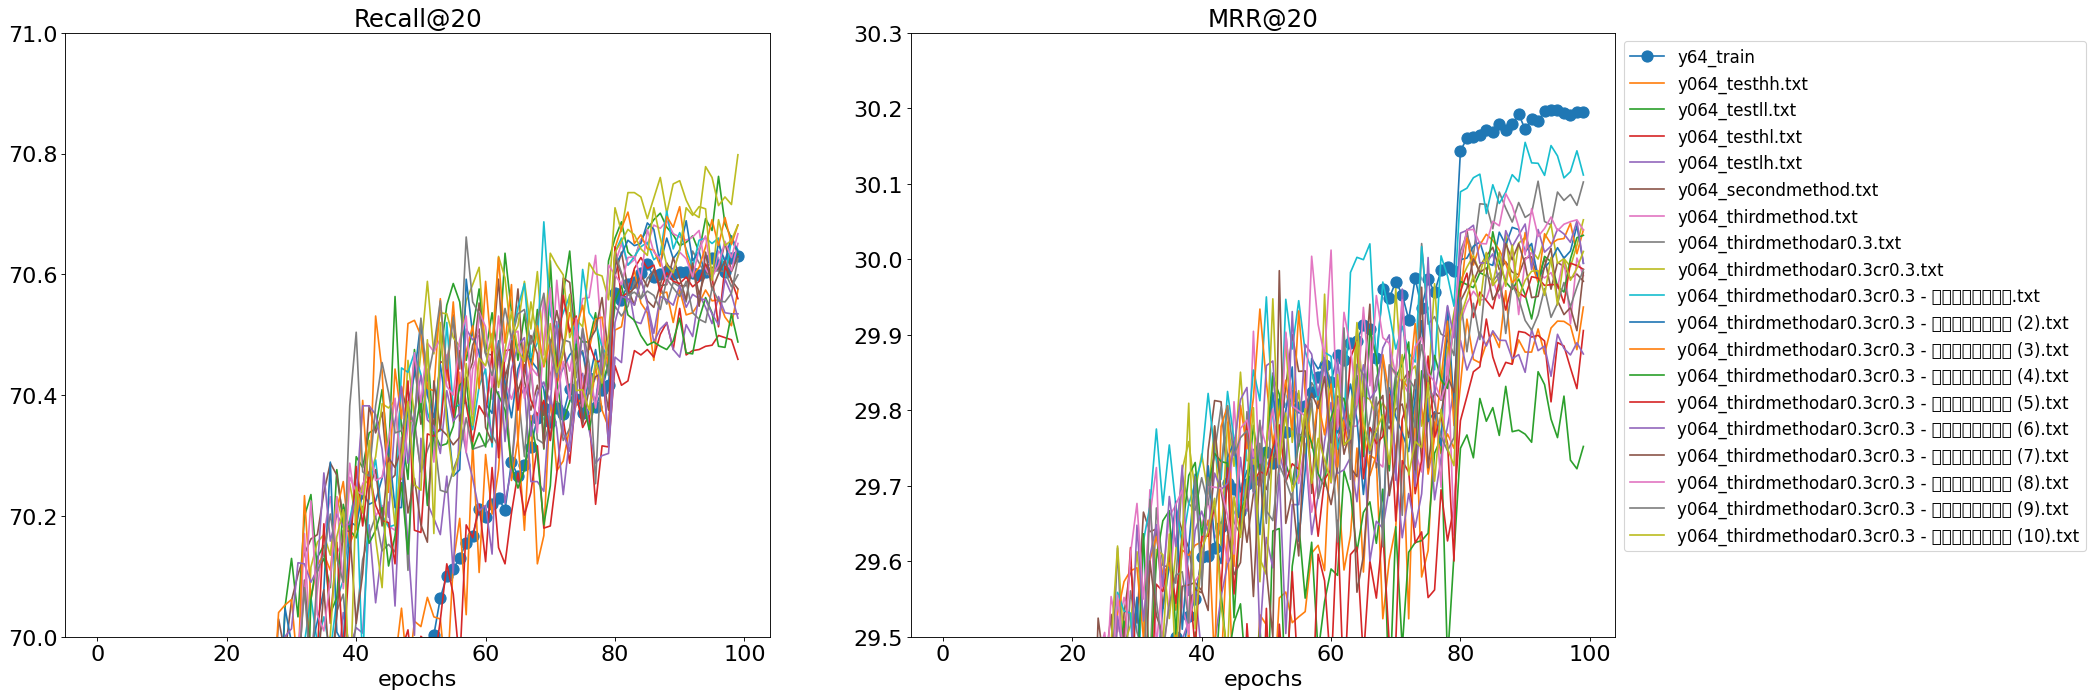

In [ ]:
experiment = 1
model='narm'  # 'narm' or 'srgnn'
y_or_d='yoochoose'  # 'yoochoose' or 'diginetica'
h_or_m='h'  # 'h' for hits / 'm' for mrrs

plot_result(model, experiment, y_or_d, 1/64, microscope_h=[70, 71], microscope_m=[29.5, 30.3])